## Background
Company XYZ is an e-commerce site that sells hand-made clothes. You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.
You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud")

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator

import  warnings
warnings.simplefilter('ignore')

In [2]:
df_fraud_original = pd.read_csv('Fraud.csv', parse_dates=['signup_time', 'purchase_time'])
df_ip_country_original = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
df_fraud = df_fraud_original.copy()
df_fraud.drop(columns='Unnamed: 0', axis=1,inplace=True)
df_fraud

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0
...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0


In [4]:
df_ip_country = df_ip_country_original.copy()
df_ip_country

,lower_bound_ip_address,upper_bound_ip_address,country
0,1.677722e+07,16777471,Australia
1,1.677747e+07,16777727,China
2,1.677773e+07,16778239,China
3,1.677824e+07,16779263,Australia
4,1.677926e+07,16781311,China
...,...,...,...
138841,3.758092e+09,3758093311,Hong Kong
138842,3.758093e+09,3758094335,India
138843,3.758095e+09,3758095871,China
138844,3.758096e+09,3758096127,Singapore


## Task01
* For each user, determine her country based on the numeric IP address.

In [5]:
countries = []
for i in range(len(df_fraud)):
    ip_address = df_fraud.loc[i, 'ip_address']
    tmp = df_ip_country[(df_ip_country['lower_bound_ip_address'] <= ip_address) &
                          (df_ip_country['upper_bound_ip_address'] >= ip_address)]
    if len(tmp) == 1:
        countries.append(tmp['country'].values[0])
    else:
        countries.append('NA')
        
df_fraud['country'] = countries

df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [6]:
df = df_fraud.copy()

## Task02
* Build a model to predict whether an activity is fraudulent or not. 
* Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

### I. Feature Engineering

(1) Time gap could be a useful variable to identify fraud

In [7]:
# Create a column that shows the time difference between purchase time and signup time
time_gap = df['purchase_time'] - df['signup_time']
time_gap = time_gap.apply(lambda x:x.seconds)
df['time_gap'] = time_gap

(2) Check number of user in a same devices (too many users in a same device could be an indicator of fake account)


In [8]:
# Create a column that shows the number of user in a same devices
number_user_one_device = df.groupby('device_id')['user_id'].count().reset_index()
number_user_one_device = number_user_one_device.rename(columns={'user_id':'num_user_one_device'})
df = pd.merge(left=df, right=number_user_one_device, how='left', on='device_id')

(3) Check number of user in a same ip (too many users in a same ip could be an indicator of fake account)


In [9]:
# Create a column that shows the number of user in a same ip_address
number_user_one_ip = df.groupby('ip_address')['user_id'].count().reset_index()
number_user_one_ip = number_user_one_ip.rename(columns={'user_id':'num_user_one_ip'})
df = pd.merge(left=df, right=number_user_one_ip, how='left', on='ip_address')

(4) The day of the week and the week of the year could be a useful variable to identify fraud

In [10]:
# Create a column that shows sign up day_of_week and week_of_year
df['signup_day_of_week'] = df['signup_time'].apply(lambda x: x.dayofweek)
df['signup_week_of_year'] = df['signup_time'].apply(lambda x: x.week)

# Create a column that shows purchase day_of_week and week_of_year
df['purchase_day_of_week'] = df['purchase_time'].apply(lambda x: x.dayofweek)
df['purchase_week_of_year'] = df['purchase_time'].apply(lambda x: x.week)

In [11]:
df.sample(10)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_gap,num_user_one_device,num_user_one_ip,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year
49355,360303,2015-04-12 01:04:08,2015-07-24 22:04:07,54,BTHKIIHWUVGLR,Ads,Chrome,F,46,4.548709e+08,0,China,75599,1,1,6,15,4,30
81600,342120,2015-05-17 10:23:55,2015-06-27 20:35:30,56,DSTLQMJVSMQVB,Ads,IE,M,31,1.753670e+09,0,United States,36695,1,1,6,20,5,26
108726,284108,2015-05-06 13:02:13,2015-07-03 03:38:35,53,HTENWMNRKMMAA,SEO,Chrome,M,48,2.127820e+09,0,Japan,52582,2,1,2,19,4,27
65866,241936,2015-03-22 13:12:38,2015-05-10 21:34:33,48,LODEGITOOQHSO,Ads,Chrome,F,33,1.965438e+09,0,China,30115,1,1,6,12,6,19
30133,230349,2015-08-15 05:33:40,2015-10-08 13:37:33,24,SUBPTNAPPNCLL,Ads,FireFox,F,23,3.117508e+08,0,United States,29033,1,1,5,33,3,41
147160,71691,2015-08-17 16:04:00,2015-11-19 14:42:48,16,FWVMCARVNVTVV,Ads,IE,F,24,4.028843e+09,0,NA,81528,1,1,0,34,3,47
130070,188259,2015-06-19 05:40:22,2015-07-29 02:13:06,45,UIBEELMNPKUYP,Ads,IE,M,23,7.725579e+08,0,Greece,73964,1,1,4,25,2,31
86072,127346,2015-02-16 23:39:17,2015-03-15 01:51:14,22,WHUTCHOSAHXRW,SEO,Chrome,M,27,3.522467e+09,0,United States,7917,1,1,0,8,6,11
99515,347845,2015-04-16 21:50:25,2015-06-20 01:20:14,40,KRGOYCWFOQVJV,Direct,IE,F,37,2.968125e+07,0,China,12589,1,1,3,16,5,25
102399,41743,2015-05-06 09:12:17,2015-08-24 16:38:54,67,WUDEAYPNGMBTX,Ads,Chrome,M,39,2.933946e+09,0,United States,26797,1,1,2,19,0,35


### II. Define features and target to make new dataset for model

In [13]:
# Define features and target to be used
columns = ['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_gap', 
           'num_user_one_device', 'num_user_one_ip', 'signup_day_of_week', 'signup_week_of_year',
          'purchase_day_of_week', 'purchase_week_of_year','class']
df_model = df[columns]
df_model.head()

,purchase_value,source,browser,sex,age,country,time_gap,num_user_one_device,num_user_one_ip,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year,class
0,34,SEO,Chrome,M,39,Japan,13882,1,1,1,9,5,16,0
1,16,Ads,Chrome,F,53,United States,17944,1,1,6,23,0,24,0
2,15,SEO,Opera,M,53,United States,1,12,8,3,1,3,1,1
3,44,SEO,Safari,M,41,NA,60085,1,1,1,18,0,19,0
4,39,Ads,Safari,M,45,United States,41461,1,1,1,30,2,37,0


### III. Machine Learning Model

* We use H2o Random Forest model 

In [14]:
# Initialize H2O cluster
h2o.init()
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM (build 11.0.6+8-b765.1, mixed mode)
  Starting server from C:\Users\14152\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\14152\AppData\Local\Temp\tmp6gmq8f81
  JVM stdout: C:\Users\14152\AppData\Local\Temp\tmp6gmq8f81\h2o_Leo_started_from_python.out
  JVM stderr: C:\Users\14152\AppData\Local\Temp\tmp6gmq8f81\h2o_Leo_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.1.3
H2O_cluster_version_age:,1 month and 25 days
H2O_cluster_name:,H2O_from_python_Leo_maby21
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.951 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"accepting new members, healthy"


In [15]:
# Transform to H2O Frame, and make sure the target variable is categorical
df_h2o = H2OFrame(df_model)

for name in ['source', 'browser', 'sex', 'country', 'signup_day_of_week',
             'purchase_day_of_week','signup_week_of_year','purchase_week_of_year', 'class']:
    df_h2o[name] = df_h2o[name].asfactor()

df_h2o.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,purchase_value,source,browser,sex,age,country,time_gap,num_user_one_device,num_user_one_ip,signup_day_of_week,signup_week_of_year,purchase_day_of_week,purchase_week_of_year,class
type,int,enum,enum,enum,int,enum,int,int,int,enum,enum,enum,enum,enum
mins,9.0,,,,18.0,,1.0,1.0,1.0,,,,,
mean,36.93537243898597,,,,33.14070358409676,,40942.58442744483,1.6843665625496307,1.3041849753825019,,,,,
maxs,154.0,,,,76.0,,86399.0,20.0,13.0,,,,,
sigma,18.322762148662157,,,,8.617733490961474,,26049.66190211843,2.616953602804177,1.3672671245454877,,,,,
zeros,0,,,,0,,0,0,0,,,,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,34.0,SEO,Chrome,M,39.0,Japan,13882.0,1.0,1.0,1,9,5,16,0
1,16.0,Ads,Chrome,F,53.0,United States,17944.0,1.0,1.0,6,23,0,24,0
2,15.0,SEO,Opera,M,53.0,United States,1.0,12.0,8.0,3,1,3,1,1


In [18]:
# Split into 75% training and 25% test dataset
split = df_h2o['class'].stratified_split(test_frac=0.25, seed=11)

train = df_h2o[split == 'train']
test = df_h2o[split == 'test']

feature = ['purchase_value', 'source', 'browser', 'sex', 'age', 'country', 'time_gap', 
           'num_user_one_device', 'num_user_one_ip', 'signup_day_of_week', 'signup_week_of_year',
          'purchase_day_of_week', 'purchase_week_of_year']

target = 'class'

In [19]:
# Build random forest model
model = H2ORandomForestEstimator(ntrees=100, stopping_rounds=5, stopping_metric='auc', 
                                 score_each_iteration=True, seed=11)
model.train(x=feature, y=target, training_frame=train, validation_frame=test)

drf Model Build progress: |███████████████████████████████████████████████| 100%


In [20]:
# feature importance
importance = model.varimp(use_pandas=True)
importance

,variable,relative_importance,scaled_importance,percentage
0,time_gap,41626.812500,1.000000,0.220619
1,purchase_week_of_year,36838.675781,0.884975,0.195242
2,num_user_one_ip,34307.402344,0.824166,0.181826
3,num_user_one_device,25267.253906,0.606995,0.133914
4,signup_week_of_year,16545.822266,0.397480,0.087691
5,country,9617.552734,0.231042,0.050972
6,purchase_value,4854.092773,0.116610,0.025726
7,age,4843.158203,0.116347,0.025668
8,signup_day_of_week,4502.559082,0.108165,0.023863
9,purchase_day_of_week,4429.342773,0.106406,0.023475


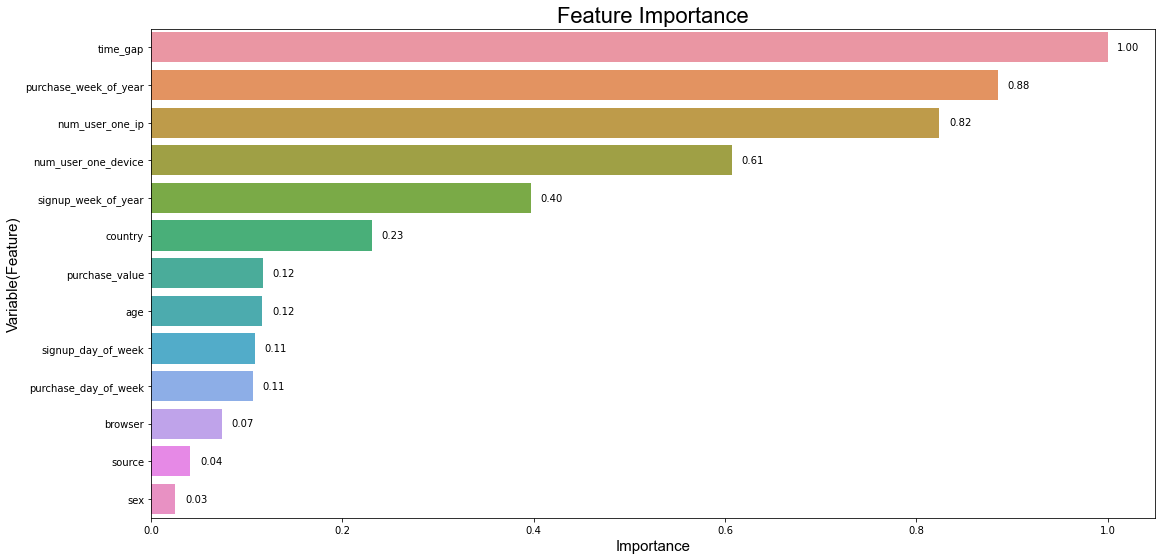

In [21]:
# Feature importance plot
fig, ax = plt.subplots(figsize=(18,9))
ax = sns.barplot(x='scaled_importance', y='variable', data=importance)

for p in ax.patches:
    width = p.get_width()    # get bar length
    ax.text(width + 0.01,       # set the text at 1 unit right of the bar
            p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
            '{:1.2f}'.format(width), # set variable to display, 2 decimals
            ha = 'left',   # horizontal alignment
            va = 'center')  # vertical alignment

plt.title('Feature Importance', fontdict={'fontname': 'Arial', 'fontsize': 22})
plt.xlabel('Importance', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.ylabel('Variable(Feature)', fontdict={'fontname': 'Arial', 'fontsize': 15})
plt.show()

In [22]:
# Make predictions
train_true = train.as_data_frame()['class'].values
test_true = test.as_data_frame()['class'].values
train_pred = model.predict(train).as_data_frame()['p1'].values
test_pred = model.predict(test).as_data_frame()['p1'].values


drf prediction progress: |████████████████████████████████████████████████| 100%
drf prediction progress: |████████████████████████████████████████████████| 100%


In [23]:
# Classification report
# Set Threshold as 0.5
prob_threshold = 0.5
print(classification_report(y_true=test_true, y_pred=(test_pred > prob_threshold).astype(int)))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     34240
           1       0.99      0.54      0.70      3538

    accuracy                           0.96     37778
   macro avg       0.97      0.77      0.84     37778
weighted avg       0.96      0.96      0.95     37778



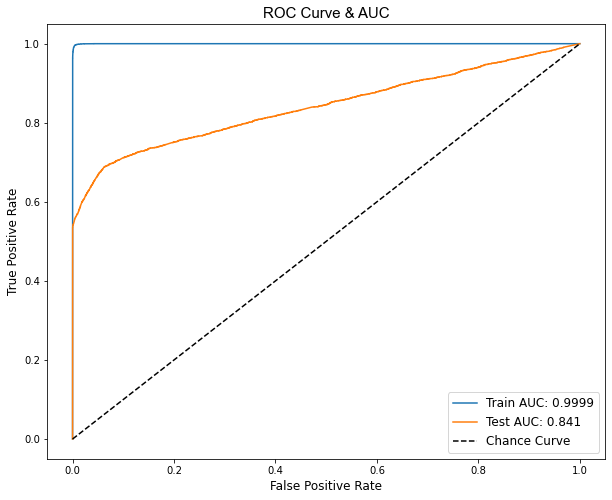

In [24]:
# ROC curve & AUC
train_fpr, train_tpr, train_threshold = roc_curve(train_true, train_pred)
test_fpr, test_tpr, test_threshold = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 4)
test_auc = np.round(auc(test_fpr, test_tpr), 4)

# ROC curve & AUC plot
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(train_fpr, train_tpr, label=f'Train AUC: {train_auc}')
ax.plot(test_fpr, test_tpr, label=f'Test AUC: {test_auc}')
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
plt.title('ROC Curve & AUC', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

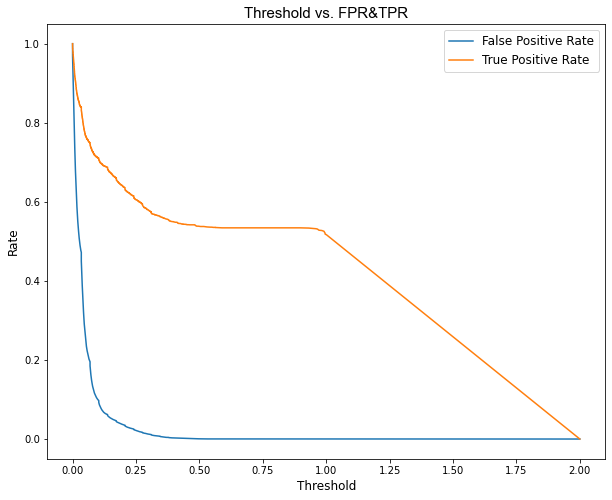

In [25]:
# Shows the correlation between thresholds and FPR & TPR
roc_results = {'FPR': test_fpr, 'TPR': test_tpr, 'Threshold': test_threshold}
roc_results = pd.DataFrame(roc_results)

# Plot
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(roc_results['Threshold'], roc_results['FPR'],label='False Positive Rate')
ax.plot(roc_results['Threshold'], roc_results['TPR'],label='True Positive Rate')
plt.title('Threshold vs. FPR&TPR', fontdict={'fontname': 'Arial', 'fontsize': 15})
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Rate', fontsize=12)
ax.legend(fontsize=12)
plt.show()

### Explain how different assumptions about the cost of false positives vs false negatives would impact the model.
1. From above two plots:

  * If false positive cost much higher, we should increase the probability threshold, but our TPR will also be decreased.
  * if false negative cost much higher, we should decrease the probability threshold, but our FPR will also be increased.



2. 
    In this case, because normally this "Fraud Detection Model" is often used in a pre-screening step, the results will be further investigated by expert, 

   So,
   
   * If 'Not Fraud' is classified as 'Fraud', human expert can still have method to fix the problem.
   * but if 'Fraud' is classified as 'Not Fraud', the company will lose money directly.
    
**Therefore, "false negative" cost much higher in identifying fraudulent, so we should choose a relatively smaller threshold.**

In [27]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_abb1 closed.


## Task03
* Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

We can set up a "Two-step authentication" and we divide the users into three groups based on my model predicts the probability that the purchase is fraudulent

1. Low risk user gorup: the probability is less than 10%, we can assume the purchase is normal, directly passed.
2. Medium risk user gorup: the probability is between 10-50%, we can assume the purchase is suspicious, use the two-step authentication.
3. High risk user gorup: the probability is more than 50%, we can assume the purchase is highly suspicious, blocked.